In [20]:
import sys
sys.path.append('/home/599/dbi599/ocean-analysis/modules')
import warnings
warnings.filterwarnings('ignore')
import glob

import iris
import iris.analysis.cartography
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cmocean

import convenient_universal as uconv
import timeseries
import general_io as gio

### Read data

In [2]:
var_names = {'wfo': 'water_flux_into_sea_water',
             'hfds': 'surface_downward_heat_flux_in_sea_water',
             'bigthetao': 'sea_water_conservative_temperature'}


def read_data(var, experiment):
    """Read wfo or hfds files"""
    infiles = glob.glob(f'/g/data/r87/dbi599/CMIP6/FAFMIP/KEWEI-LYU/ACCESS-OM2/{experiment}/r1i1p1f1/Omon/{var}/gn/v20191210/{var}_Omon_ACCESS-OM2_{experiment}_r1i1p1f1_gn_*.nc')
    cube, history = gio.combine_files(infiles, var_names[var])
    if var in ['wfo', 'hfds']:
        cube = uconv.flux_to_magnitude(cube)
        cube = timeseries.convert_to_annual(cube, aggregation='sum')
    elif var == 'bigthetao':
        assert cube.ndim == 4
        cube = timeseries.convert_to_annual(cube[:, 0, ::], aggregation='mean', days_in_month=True)
        cube = gio.temperature_unit_check(cube, 'C')
    
    return cube

In [3]:
cube_dict = {}
for var in ['wfo', 'hfds', 'bigthetao']:
    for exp in ['faf-passiveheat', 'faf-heat', 'faf-water']:
        print(var, exp)
        cube_dict[(var, exp)] = read_data(var, exp)

wfo faf-passiveheat
wfo faf-heat
wfo faf-water
hfds faf-passiveheat
hfds faf-heat
hfds faf-water
bigthetao faf-passiveheat
bigthetao faf-heat
bigthetao faf-water


### Climatology

In [21]:
def plot_climatology(var):
    """Plot the climatology"""

    if var == 'wfo':
        vmax = 2000
        cmap = cmocean.cm.diff_r
        title_name = 'total annual net surface water flux'
    elif var == 'hfds':
        vmax = 5e9
        cmap = cmocean.cm.balance
        title_name = 'total annual net surface heat flux'
    
    color_cube, extent = iris.analysis.cartography.project(cube_dict[(var, 'faf-passiveheat')][0, ::],
                                                           ccrs.PlateCarree(), nx=400, ny=200)
    contour_cube, extent = iris.analysis.cartography.project(cube_dict[('bigthetao', 'faf-passiveheat')][0, ::],
                                                             ccrs.PlateCarree(), nx=400, ny=200)
    fig = plt.figure(figsize=[15, 15])
    ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))
    ax.set_global()
    color_plot = qplt.pcolormesh(color_cube, vmin=-vmax, vmax=vmax, cmap=cmap)
    contour_plot = qplt.contour(contour_cube, colors='black',
                                levels=[4, 8, 12, 16, 20, 24, 26, 28, 29])
    ax.clabel(contour_plot, inline=True, fontsize=10, fmt='%2.1f')
    ax.set_title(f'{title_name}, faf-passiveheat, year=0')
    ax.coastlines()
    plt.savefig(f'/g/data/r87/dbi599/temp/{var}_faf-passiveheat_clim.png', bbox_inches='tight', dpi=300)

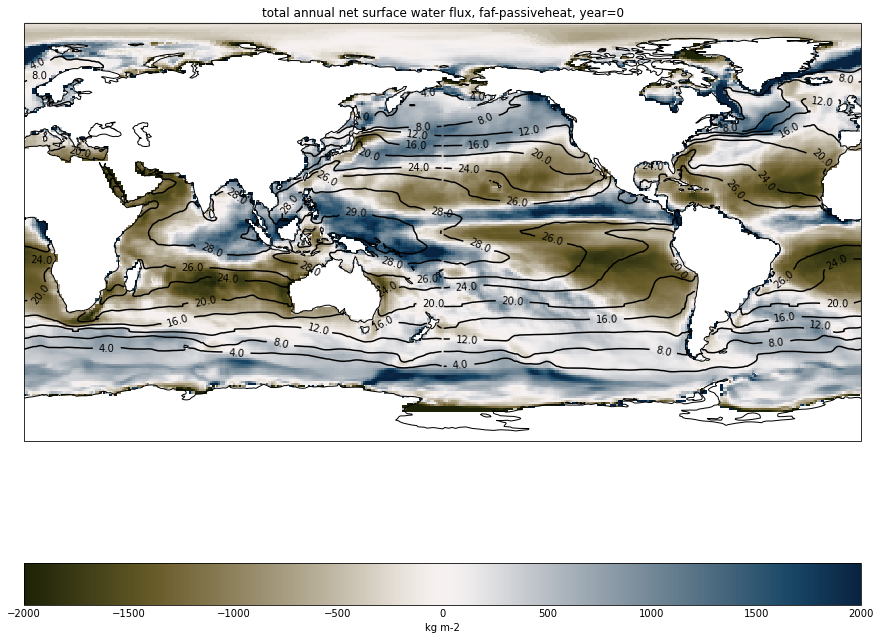

In [22]:
plot_climatology('wfo')

**Figure 1.** Total annual net surface water flux for the first year of the `faf-passiveheat` experiment. Contours show the annual mean sea surface temperature (C) from the first year of the `faf-passiveheat` experiment.

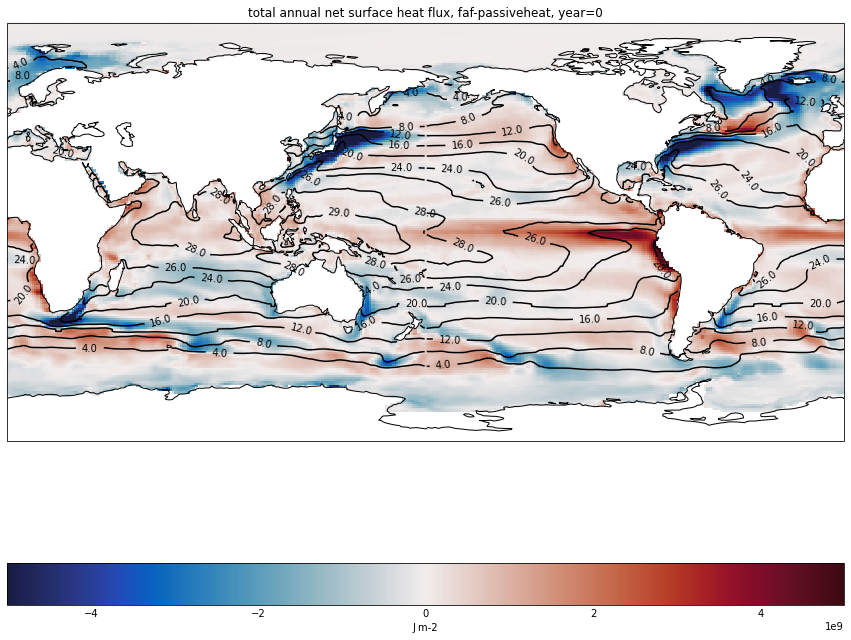

In [23]:
plot_climatology('hfds')

**Figure 2.** Total annual net surface heat flux for the first year of the `faf-passiveheat` experiment. Contours show the annual mean sea surface temperature (C) from the first year of the `faf-passiveheat` experiment.

### Cumulative anomaly

In [27]:
def plot_cumulative_anomaly(var, exp):
    """Plot the cumulative anomaly"""

    exp_cube = cube_dict[(var, exp)]
    control_cube = cube_dict[(var, 'faf-passiveheat')]
    anomaly_cube = exp_cube[-1, ::].copy()
    anomaly_cube.data = np.sum(exp_cube.data, axis=0) - np.sum(control_cube.data, axis=0)
    
    if var == 'wfo':
        cmap = cmocean.cm.diff_r
        title_name = 'net surface water flux'
        vmax = 3e4
    elif var == 'hfds':
        vmax = 5e10
        cmap = cmocean.cm.balance
        title_name = 'net surface heat flux'
    
    color_cube, extent = iris.analysis.cartography.project(anomaly_cube, ccrs.PlateCarree(), nx=400, ny=200)
    contour_cube, extent = iris.analysis.cartography.project(cube_dict[('bigthetao', 'faf-passiveheat')][0, ::],
                                                             ccrs.PlateCarree(), nx=400, ny=200)
    fig = plt.figure(figsize=[15, 15])
    ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))
    ax.set_global()
    color_plot = qplt.pcolormesh(color_cube, vmin=-vmax, vmax=vmax, cmap=cmap)
    contour_plot = qplt.contour(contour_cube, colors='black',
                                levels=[4, 8, 12, 16, 20, 24, 26, 28, 29])
    ax.clabel(contour_plot, inline=True, fontsize=10, fmt='%2.1f')
    ax.set_title(f'{title_name} cumulative anomaly, {exp}, year=70')
    ax.coastlines()
    plt.savefig(f'/g/data/r87/dbi599/temp/{var}_{exp}_cumulative_anomaly.png', bbox_inches='tight', dpi=300)

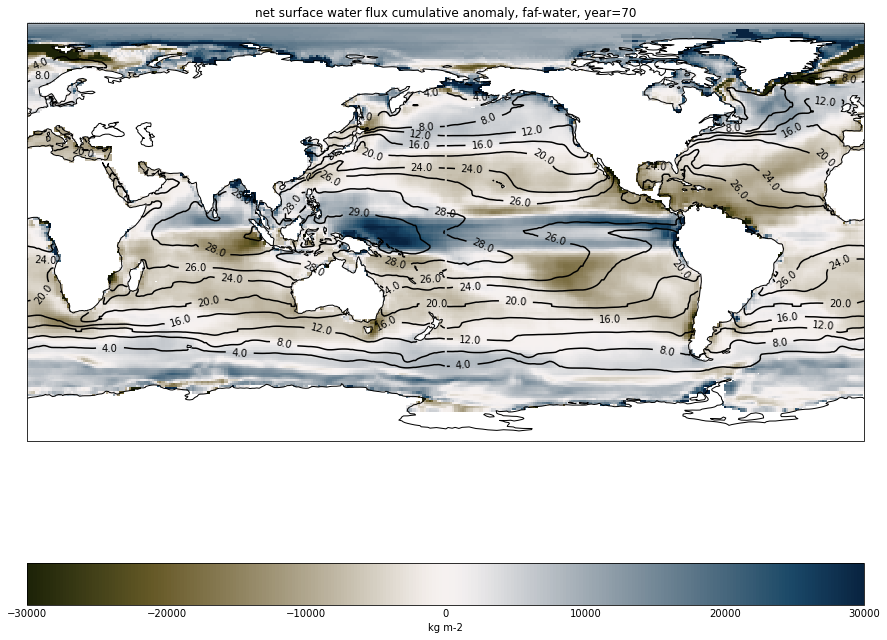

In [28]:
plot_cumulative_anomaly('wfo', 'faf-water')

**Figure 3.** Time-integrated net surface water flux anomaly at the end of the `faf-water` experiment (i.e. year 70). Contours show the annual mean sea surface temperature (C) from the first year of the `faf-passiveheat` experiment.

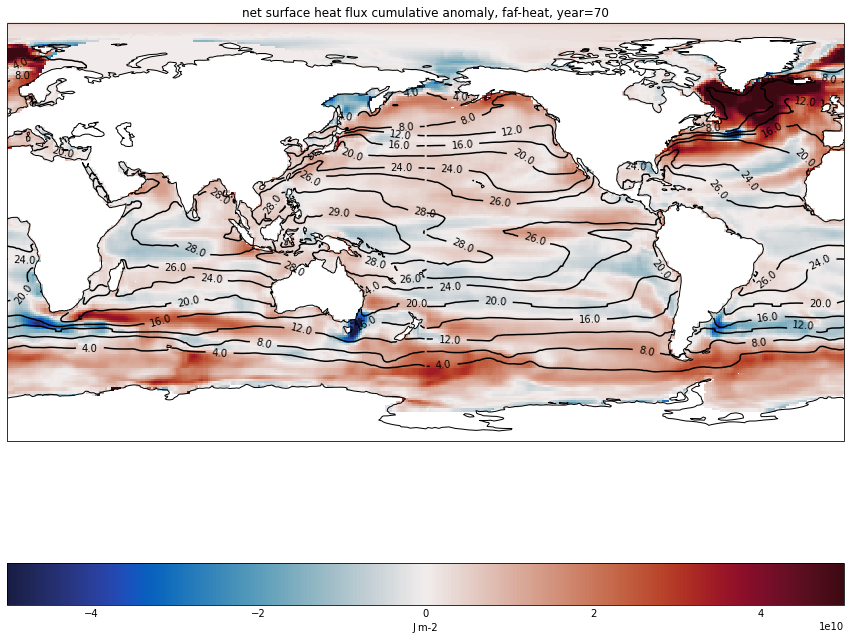

In [26]:
plot_cumulative_anomaly('hfds', 'faf-heat')

**Figure 4.** Time-integrated net surface heat flux anomaly at the end of the `faf-heat` experiment (i.e. year 70). Contours show the annual mean sea surface temperature (C) from the first year of the `faf-passiveheat` experiment.